## Sentiment Analysis

### Code Setup and Data Loading

In [122]:
# it is necessary to install fsspec, fastparquet and huggingface_hub
# pip install fsspec
# pip install huggingface_hub
# pip install fastparquet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

# run these as needed
#nltk.download('stopwords')
#nltk.download('punkt_tab')
#nltk.download('wordnet')

#### Data sourced from Hugging Face post by Tim Koonstra
https://huggingface.co/datasets/TimKoornstra/financial-tweets-sentiment

In [31]:
df = pd.read_parquet("hf://datasets/TimKoornstra/financial-tweets-sentiment/data/train-00000-of-00001.parquet")

In [32]:
# Koornstra's tweet sentiment
# 0 - neutral
# 1 - positive
# 2 - negative

### Text Preprocessor

In [79]:

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))
#import spacy

def custom_preprocessor(s):
    s2 = s.lower()
    
    words = nltk.word_tokenize(s2)
    new_text = ""
    for word in words:
        word = word.strip()
        if word not in stop_words and len(word) > 1:
            word = re.sub('[^A-Za-z0-9]+', '', word)
            word = lemmatizer.lemmatize(word)
            new_text = new_text + " " + word        
    
    new_text = new_text.strip()
    return new_text

#### data cleanup, apply preprocessor here rather than in TfidfVectorizer so that we can actually see the transformed data

In [80]:
df['url'] = df.tweet.str.extract(r'(https.*)')
df['ticker'] = df.tweet.str.extract(r'(\$[A-Z]*)')
df['ticker'] = df['ticker'].str.replace('$','', regex=False)
df['clean_tweet'] = df['tweet']
df['clean_tweet'] = df.apply(lambda x: x['clean_tweet'].replace(str(x['url']), ''), axis=1)
df['clean_tweet'] = df.apply(lambda x: x['clean_tweet'].replace(str(x['ticker']), ''), axis=1)
df['clean_tweet'] = df.apply(lambda x: x['clean_tweet'].replace('&amp;', ''), axis=1)
df['clean_tweet'] = df.apply(lambda x: x['clean_tweet'].replace('\n', ''), axis=1)
df['clean_tweet'] = df.apply(lambda x: x['clean_tweet'].replace("n't", ' not'), axis=1) #let see if this helps on the negatice preds
df['clean_tweet'] = df['clean_tweet'].str.replace('(\$\w+.*?)','', regex=True)
df['clean_tweet'] = df['clean_tweet'].str.replace('(\@\w+.*?)','', regex=True)
df['clean_tweet'] = df['clean_tweet'].str.replace('[-:,$@]','', regex=True)

In [81]:
#so we can see what it's doing run the preprocessor over the dataset
df['preprocessed_text'] = df.apply(lambda x: custom_preprocessor(x['clean_tweet']), axis=1)
df['wordcount'] = df.apply(lambda x: len(x['preprocessed_text'].split(' ')), axis=1)

In [82]:
df.head()

,tweet,sentiment,url,ticker,clean_tweet,preprocessed_text,wordcount
0,$BYND - JPMorgan reels in expectations on Beyo...,2,https://t.co/bd0xbFGjkT,BYND,JPMorgan reels in expectations on Beyond Meat,jpmorgan reel expectation beyond meat,5
1,$CCL $RCL - Nomura points to bookings weakness...,2,https://t.co/yGjpT2ReD3,CCL,Nomura points to bookings weakness at Carni...,nomura point booking weakness carnival royal c...,7
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",2,https://t.co/KN1g4AWFIb,CX,Cemex cut at Credit Suisse J.P. Morgan on we...,cemex cut credit suisse jp morgan weak buildin...,9
3,$ESS: BTIG Research cuts to Neutral https://t....,2,https://t.co/MCyfTsXc2N,ESS,BTIG Research cuts to Neutral,btig research cut neutral,4
4,$FNKO - Funko slides after Piper Jaffray PT cu...,2,https://t.co/z37IJmCQzB,FNKO,Funko slides after Piper Jaffray PT cut,funko slide piper jaffray pt cut,6


### Visualizing the Dataset

In [95]:
words = []
df.apply(lambda x: words.append(x['preprocessed_text'].split(' ')), axis=1)
flat_vocab = [x for y in words for x in y]
vocab_series = pd.Series(flat_vocab)
vocab = pd.DataFrame({'word': vocab_series.values}).value_counts()


Text(0.5, 1.0, 'Vocabulary Distribution')

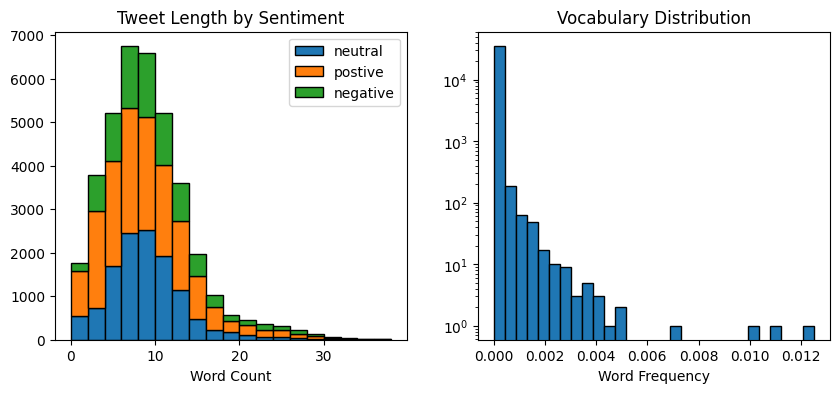

In [115]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
# tweet length plot
s0 = list(df[df['sentiment'] == 0]['wordcount'])
s1 = list(df[df['sentiment'] == 1]['wordcount'])
s2 = list(df[df['sentiment'] == 2]['wordcount'])
names = ['neutral','postive','negative']
ax1.hist([s0,s1,s2], bins=range(0,40,2), stacked=True, label=names, edgecolor='black')
ax1.legend()
ax1.set_xlabel('Word Count')
ax1.set_title('Tweet Length by Sentiment')

#build vocab for frequency distribution plot
vocab_df = pd.DataFrame(vocab)
vocab_df.reset_index(inplace=True)
vocab_df.rename(columns={0:'count'}, inplace=True)
vocab_df['frequency'] = vocab_df['count'] / len(flat_vocab)
vocab_df = vocab_df.round(4)

ax2.hist(vocab_df['frequency'], bins=np.linspace(0.0,0.0125,num=30), log=True, edgecolor='black')
ax2.set_xlabel('Word Frequency')
ax2.set_title('Vocabulary Distribution')

In [117]:
#split and set up vectors
x_train, x_test, y_train, y_test = train_test_split(df['preprocessed_text'],df['sentiment'])
#set up vectors
stop_words = list(text.ENGLISH_STOP_WORDS)
vectorizer = TfidfVectorizer(min_df = 1,
                             #max_df = 0.80,
                             #max_features = 20,
                             #sublinear_tf = True,
                             #use_idf = False
                             #stop_words = ['strike','expiration','call','put'],
                             #strip_accents='unicode',
                             #preprocessor=custom_preprocessor,
                             ngram_range=(1,2)
                            )

train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

### Prediction Results

In [118]:
#run classification
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, y_train)
prediction_linear = classifier_linear.predict(test_vectors)

report = classification_report(y_test, prediction_linear, output_dict=True)
print('neutral: ', report['0'])
print('positive: ', report['1'])
print('negative: ', report['2'])

neutral:  {'precision': 0.7676156583629893, 'recall': 0.6900191938579654, 'f1-score': 0.7267520215633423, 'support': 3126.0}
positive:  {'precision': 0.7306038894575231, 'recall': 0.8317408529480308, 'f1-score': 0.777898866608544, 'support': 4291.0}
negative:  {'precision': 0.6920131291028446, 'recall': 0.600664767331434, 'f1-score': 0.643111337061515, 'support': 2106.0}


In [ ]:
#NOTE: so far min_df of 1 seems to have the best performance.  for min_df=1, max_df range of 0.4 to 1.0 seens to have no impact
#NOTE: breaking up by sector does not help.  Often sample size is too small
#NOTE adding stop words mildly reduced precision will slightly imprving recall and f1 for neutral and negative predictions
#OBS: removing @ tags and excess symbols has helped a bit probably by removing infrequent, yet irrelevant items

In [120]:
# THIS SECTION COMMENTED OUT, USED TO TEST VARIOUS PARAMETERS FOR THE BEST FIT
#min_df_range = [1]
#max_df_range = [.40,.50,.60,.70]
#for mnd in min_df_range:
#    for mxd in max_df_range:
#        vectorizer = TfidfVectorizer(min_df = mnd,
#                                 max_df = mxd,
#                                 #sublinear_tf = True,
#                                 #use_idf = False
#                                )
#
#        train_vectors = vectorizer.fit_transform(x_train)
#        test_vectors = vectorizer.transform(x_test)
#            
#        classifier_linear = svm.SVC(kernel='linear')
#        classifier_linear.fit(train_vectors, y_train)
#        prediction_linear = classifier_linear.predict(test_vectors)

#        report = classification_report(y_test, prediction_linear, output_dict=True)
#        print('min_df: ',mnd,' ,max_df: ',mxd)
#        print('------------------------------')
#        print('neutral: ', report['0'])
#        print('positive: ', report['1'])
#        print('negative: ', report['2'])
#        print('==============================')
#        print(' ')
        

### Reviewing Some of the False Positives and False Negatives

In [121]:
test_data = pd.concat([x_test, y_test], axis=1)
test_data['pred'] = np.array(prediction_linear)
pd.set_option('max_colwidth', 200)
test_data.loc[test_data['sentiment'] != test_data['pred']].head(15)

,preprocessed_text,sentiment,pred
20970,anyone s paying attention knew arm deal probably dead reason see back earnings,1,2
2967,oil trade 3month low,2,1
14368,amzn matter look still ca figure s valued 26947,2,1
15225,vxy another ong bpop snort 9 next week vxy new high index,1,2
37822,weakest today dt watchlist,2,1
12670,typical set 2611,1,0
24124,said delay delivery timeline model plaid due delay stop taking model plaid order electrek tesla inc,2,1
520,czech unexpected rate hike lift koruna sevenyear high,0,1
6187,china s gdp growth quarter according top economist ed hyman,2,1
5533,might need much sleep think,0,1
